# Regressão logística com regularização

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/ex2data2.txt',header=None)

In [94]:
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [95]:
data.describe()

,0,1,2
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


## Visualização de dados

Text(0, 0.5, 'Microchip test 2')

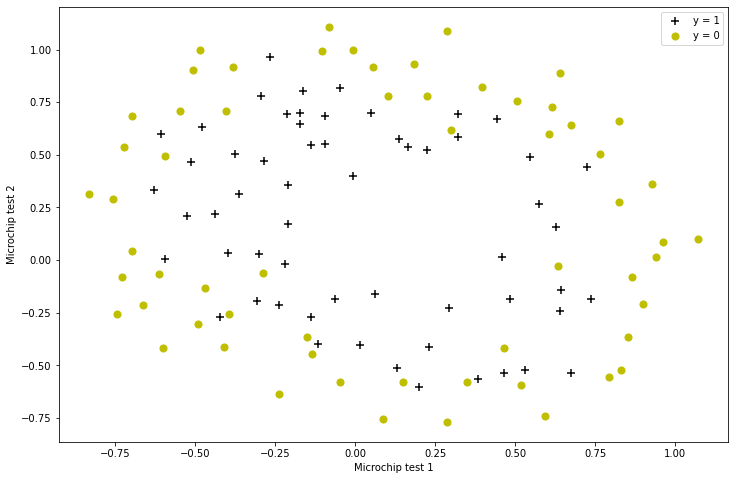

In [80]:
X = np.array(data.iloc[:,:-1])
y = np.array(data.iloc[:,-1])

pos = X[y == 1]
neg = X[y == 0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pos[:, :-1], pos[:, -1:], s=50, c='k', marker='+', label='y = 1')
ax.scatter(neg[:, :-1], neg[:, -1:], s=50, c='y', marker='o', label='y = 0')
ax.legend()
ax.set_xlabel('Microchip test 1')
ax.set_ylabel('Microchip test 2')

## Mapeamento de características

In [220]:
def mapFeature(X1, X2, degree=6):
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

def mapFeature2(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return all polynomial terms up to the given degree
    """
    out = np.ones(len(x1)).reshape(len(x1),1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j).reshape(len(x1),1)
            out= np.hstack((out,terms))
    return out

X_mf = mapFeature(X[:,0], X[:,1], 6)

## Função de custo e gradiente

In [226]:
def sigmoide(z):
    return 1.0 / (1 + np.exp(-z))

def custo_reglog(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    grad0 = np.multiply(-y, np.log(sigmoide(X * theta.T)))
    grad1 = np.multiply((1 - y), np.log(1 - sigmoide(X * theta.T)))
    return np.sum(grad0 - grad1) / (len(X))

def costFunctionReg(theta, X, y, lambda_):
    '''
    Método que calcula e atribui os valores de theta
    '''
    m = len(y)   
    theta_shape = theta.shape[0] 
    # atualização de theta
    for theta_index in range(theta_shape):
        value = 0
        for line in range(m):
            z = sigmoide(theta.T.dot(X[line]))
            value += (z - y[line]) * X[line][theta_index]

            if theta_index > 0:
                value += (lambda_/m) * theta[theta_index]

        theta[theta_index] = value
    #J = custoRegLog_Norm(theta, X, y, lambda_)
    return theta

def custoRegLog_Norm(theta, X, y, lambda_):
    '''
    Função de custo da regressão logística regularizada
    '''
    m = len(y)
    # Cálculo do custo
    cost_last_component = (lambda_ / (2*m)) * (np.sum(theta ** 2))
    J = custo_reglog(theta, X, y) +  cost_last_component
    
    return J

def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    return 1/ (1 + np.exp(-z))

def costFunctionReg2(theta, X, y ,Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize cost function and gradient
    of a logistic regression
    """
    
    m=len(y)
    y=y[:,np.newaxis]
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

initial_theta = np.zeros((X_mf.shape[1], 1))
Lambda = 1
cost=costFunctionReg(initial_theta.flatten(), X_mf, y, 1)
print("Cost at initial theta (zeros):",cost)

Cost at initial theta (zeros): [ 1.          3.71053713  1.60610272 12.64140857 -0.04488091 19.27164924
  5.79203274  2.70462066  1.91455824 11.19555426 11.72877306 -0.05630094
  4.4822958  -0.29329402 14.71259946  5.4410927   1.21273615  0.95978361
  1.76937977  0.7716796  10.48978765  8.27141828  0.08609087  1.8608433
 -0.05312379  2.18939051 -0.21004803 11.99328082]


In [245]:
def compute_cost(theta, X, y, Lambda):
    m = len(y)
    grad0 = -y @ np.log(sigmoide(X @ theta))
    grad1 = (1 - y) @ np.log(1 - sigmoide(X @ theta))
    return (np.sum(grad0 - grad1) / m) + ((Lambda / (2 * m)) * np.sum(theta ** 2))

theta = np.zeros((X_mf.shape[1], 1))
print(compute_cost(theta, X_mf, y, 1))

0.6931471805599454


In [250]:
import scipy.optimize as opt

def gradient(theta, X, y, Lambda):
    m = len(y)
    grad = (X.T @ (sigmoide(X @ theta) - y)) / m
    grad[1:] = grad[1:] + (Lambda / m) * theta[1:]
    return grad


result = opt.fmin_tnc(func=compute_cost, x0=theta, fprime=gradient, args=(X_mf, y, Lambda))
theta = result[0]
theta

array([ 1.25584139,  0.62292531,  1.19165042, -2.00619119, -0.87623454,
       -1.36732804,  0.12569892, -0.35626501, -0.35595149, -0.17124621,
       -1.45787269, -0.06559898, -0.61494124, -0.25268607, -1.18172409,
       -0.22676475, -0.20565744, -0.06239408, -0.27237762, -0.27804418,
       -0.46761003, -1.03327436,  0.01712086, -0.29653991,  0.00648472,
       -0.32637289, -0.12251488, -0.92968696])

theta:  [ 1.25584139  0.62292531  1.19165042 -2.00619119 -0.87623454 -1.36732804
  0.12569892 -0.35626501 -0.35595149 -0.17124621 -1.45787269 -0.06559898
 -0.61494124 -0.25268607 -1.18172409 -0.22676475 -0.20565744 -0.06239408
 -0.27237762 -0.27804418 -0.46761003 -1.03327436  0.01712086 -0.29653991
  0.00648472 -0.32637289 -0.12251488 -0.92968696]


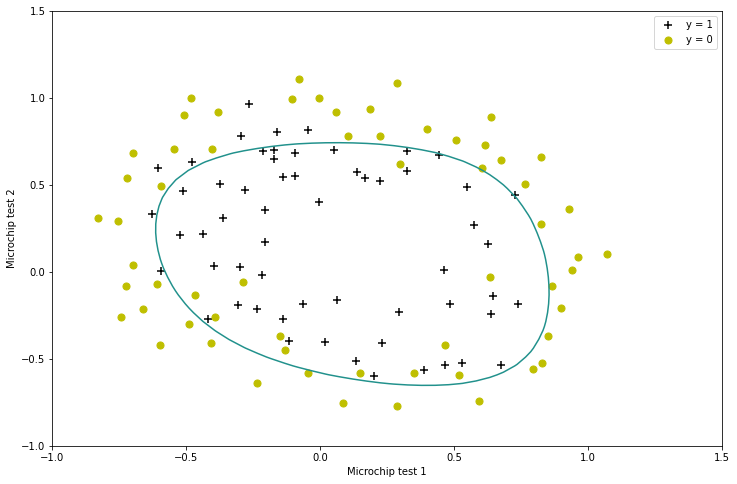

In [231]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), theta)
        
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pos[:, :-1], pos[:, -1:], s=50, c='k', marker='+', label='y = 1')
ax.scatter(neg[:, :-1], neg[:, -1:], s=50, c='y', marker='o', label='y = 0')
ax.contour(u,v,z,0)
ax.legend()
ax.set_xlabel('Microchip test 1')
ax.set_ylabel('Microchip test 2')
print('theta: ', theta)